## Where contexts helps the most

Let's check where the context really helps

In [41]:
%load_ext autoreload
%autoreload 2

from hatedetection import load_datasets
import glob
import json

train_dataset, dev_dataset, test_dataset = load_datasets(add_body=True)

evaluations = {
}



for model_name, glob_path in [
    ('no-context', "../evaluations/single-no-context-weight_[0-9]*.json"),    
    ('title', "../evaluations/single-title-weight_[0-9]*.json"),
    ('title+body', "../evaluations/single-title-body_[0-9]*.json")
    ]:
    evaluations[model_name] = []
    for path in glob.glob(glob_path):
        with open(path) as f:
            obj = json.load(f)
            obj["file"] = path
            evaluations[model_name].append(obj)

for key, evals in evaluations.items():
    print(f"We have {len(evals)} {key} evaluations")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
We have 15 no-context evaluations
We have 15 title evaluations
We have 15 title+body evaluations


In [42]:
import pandas as pd
import numpy as np
from hatedetection import extended_hate_categories

def create_df(evaluation, context):
    preds = np.array(evaluation["predictions"]).argmax(1)
    
    pred_cols = [col+"_pred" for col in extended_hate_categories]

    pepe = 1 * (np.array(evaluation["predictions"]) > 0)
    df = test_dataset.to_pandas()
    df[pred_cols] = pepe
    df["context"] = context
    df["file"] = evaluation["file"]
    assert np.allclose(df[extended_hate_categories].values, evaluation["labels"])
    
    return df

evals_df = pd.concat([
    create_df(evaluation, context) 
    for context, evaluations in evaluations.items() for evaluation in evaluations
])

## Error Analysis

Veamos algunos ejemplos de LGBTI y MUJER donde falla


Armemos primero un df de doble índice contexto x id => etiquetas predichas

In [43]:
from tqdm.auto import tqdm
from hatedetection import extended_hate_categories

df = test_dataset.to_pandas()
df.set_index("id", inplace=True)

pred_columns = [c for c in evals_df.columns if c.endswith("_pred")]

"""
Calculemos las predicciones acá
"""
preds = evals_df.groupby(["context", "id"])[pred_columns].mean()

preds.columns = [c.split("_", 1)[0] for c in preds.columns]


preds = preds.reset_index()


true_labels = df[extended_hate_categories].reset_index().copy()
true_labels["context"] = "true"

df = pd.concat([preds]).set_index(["context", "id"])
df


CALLS  WOMEN  LGBTI    RACISM  CLASS  POLITICS  DISABLED  \
context    id                                                                 
no-context 327563    0.0    0.0    0.0  0.000000    0.0       0.0       0.0   
           327564    0.0    0.0    0.0  0.000000    0.0       0.0       0.0   
           327565    0.0    0.0    0.0  0.000000    0.0       0.0       0.0   
           327566    0.0    0.0    0.0  0.000000    0.0       0.0       0.0   
           327567    0.0    0.0    0.0  0.000000    0.0       0.0       0.0   
...                  ...    ...    ...       ...    ...       ...       ...   
title+body 407597    0.0    0.0    0.0  0.933333    0.0       0.4       0.0   
           407598    0.0    0.0    0.0  0.000000    0.0       0.0       0.0   
           407599    0.0    0.0    0.0  0.866667    0.0       0.0       0.0   
           407600    0.0    0.0    0.0  0.000000    0.0       0.0       0.0   
           407601    0.0    0.0    0.0  0.000000    0.0       0.0       0.0   

                   APPEARANCE  CRIMINAL  
context    id                            
no-context 327563         0.0       0.0  
           327564         0.0       0.0  
           327565         0.0       0.0  
           327566         0.0       0.0  
           327567         0.0       0.0  
...                       ...       ...  
title+body 407597         0.0       0.0  
           407598         0.0       0.0  
           407599         0.0       0.0  
           407600         0.0       0.0  
           407601         0.0       0.0  

[34029 rows x 9 columns]

Busquemos

- Los LGBTI que con contexto encontró pero no sin
- Los LGBTI que no encontró ni con una ni con otra

## LGBTI

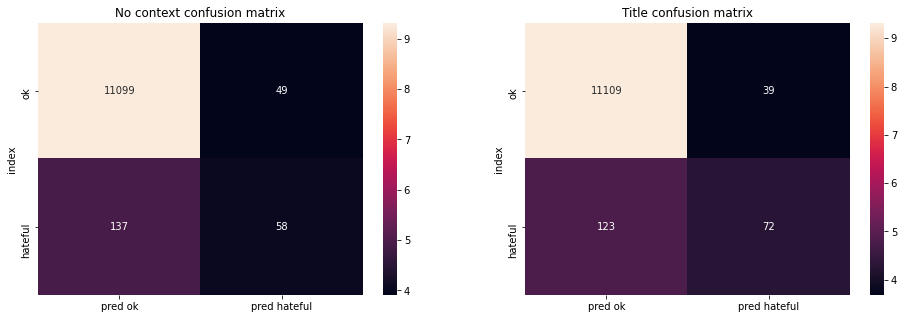

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def build_char_df(characteristic):
    """
    Build a dataframe for a given characteristic

    """
    full_test_df = test_dataset.to_pandas().set_index("id")

    char_df = full_test_df.copy()
    char_df["label"] = char_df[characteristic]

    char_df.drop([c for c in char_df.columns if c not in {"title", "text", "label"}], axis=1, inplace=True)

    # OJO ACA. Ese loc sirve para ordenar porque si no compara fruta
    char_df["no-context-pred"] = df.loc["no-context"].loc[full_test_df.index, characteristic]
    char_df["title-pred"] = df.loc["title"].loc[full_test_df.index, characteristic]
    return char_df 

characteristic = "LGBTI"
char_df = build_char_df(characteristic)

char_gold = char_df["label"] > 0
no_context_pred = char_df["no-context-pred"] > 0.5 
context_pred = char_df["title-pred"] > 0.5



plt.figure(figsize=(16, 5))

for i, (title, pred) in enumerate([
        ("No context confusion matrix", no_context_pred),
        ("Title confusion matrix", context_pred),
        ]):
    cm = pd.DataFrame(
        confusion_matrix(char_gold, pred)
    )

    cm.columns = ["pred ok", "pred hateful"]

    cm["index"] = ["ok", "hateful"]

    cm.set_index("index", inplace=True)

    normalized = np.log(1+cm)
    #normalized = (cm - cm.mean(axis=0)) / cm.std(axis=0)
    plt.subplot(1, 2, i+1)
    sns.heatmap(normalized, annot=cm, fmt="")
    plt.title(title)

Ahora si, primero veamos:

- Los que son odiosos, contexto marcó y sin contexto no

In [54]:
pd.options.display.max_colwidth = 300
char_df.loc[(char_gold & context_pred & (~no_context_pred))].sort_values(["no-context-pred", "title-pred"], ascending=[True, False])

,text,title,label,no-context-pred,title-pred
id,,,,,
397517,[USER] Ojalá consiga ayuda psiquiátrica.,Así luce el actor Elliot Page tras declararse trans,1,0.000000,1.000000
397526,[USER] Sigue teniendo concha?,Así luce el actor Elliot Page tras declararse trans,1,0.000000,1.000000
397533,[USER] Incogible,Así luce el actor Elliot Page tras declararse trans,1,0.000000,1.000000
398902,[USER] Jjaja que pinta de choma,Mara Gómez cumple su sueño: será la primera futbolista transgénero en el torneo profesional argentino,1,0.000000,0.933333
398894,[USER] Feminismo pierde de nuevo... ya le metieron un tipo... jaja punto para el patriarcado...,Mara Gómez cumple su sueño: será la primera futbolista transgénero en el torneo profesional argentino,1,0.000000,0.800000
398920,"[USER] Mara ""garrote"" Gómez",Mara Gómez cumple su sueño: será la primera futbolista transgénero en el torneo profesional argentino,1,0.000000,0.800000
405363,[USER] Pobre tipo 18 tiros...pobre tipo!!!,Una mujer trans fue asesinada de una ráfaga de 20 disparos en Rosario,1,0.000000,0.800000
405368,[USER] Pobre tipo 20 tiros. Pobre tipo. Parece un ajuste de kuentas a la mexicana.,Una mujer trans fue asesinada de una ráfaga de 20 disparos en Rosario,1,0.000000,0.733333
395354,[USER] Revienten zurdos,"El exabrupto de Jair Bolsonaro sobre el coronavirus en Brasil: ""Tienen que dejar de ser un país de maricas""",1,0.000000,0.666667


Los que ninguno encontró

In [55]:

char_df.loc[(char_gold & (~context_pred) & (~no_context_pred))].sort_values(["no-context-pred", "title-pred"], ascending=[True, True])

,text,title,label,no-context-pred,title-pred
id,,,,,
342449,[USER] Andate a la reputa madre que te parió viejo borracho !!! Hdunagranputa !!! Anda a qué te firmen el ojete a pijazos en Ezeiza !! Estos 600 casos y 15 fiambres son todos tuyos papi !!!,"Coronavirus: Ginés Gonzalez García se comparó con China y Europa y aseguró que ""hoy se habla del modelo argentino""",1,0.000000,0.000000
338091,[USER] Me dio VIH de solo ver la imagen,"Vive con sus dos novios y atiende ""la policlínica"" del amor libre: 5 preguntas para abrir una relación y sobrevivir al intento",1,0.000000,0.000000
338099,[USER] Puaj!,"Vive con sus dos novios y atiende ""la policlínica"" del amor libre: 5 preguntas para abrir una relación y sobrevivir al intento",1,0.000000,0.000000
338105,"[USER] Un asco, un verdadero quilombo y poco de amor. Más bien todo se centra en lo sexual, inmanente de una relación. Poco serio. Enfermizooo","Vive con sus dos novios y atiende ""la policlínica"" del amor libre: 5 preguntas para abrir una relación y sobrevivir al intento",1,0.000000,0.000000
338106,[USER] Terrible porquería debe ser su vida,"Vive con sus dos novios y atiende ""la policlínica"" del amor libre: 5 preguntas para abrir una relación y sobrevivir al intento",1,0.000000,0.000000
338107,[USER] Esto si que es un puterio.,"Vive con sus dos novios y atiende ""la policlínica"" del amor libre: 5 preguntas para abrir una relación y sobrevivir al intento",1,0.000000,0.000000
338115,[USER] Pensar que entre los 3 tienen todas la enfermedades venéreas que existen es ser prejuiciosa?,"Vive con sus dos novios y atiende ""la policlínica"" del amor libre: 5 preguntas para abrir una relación y sobrevivir al intento",1,0.000000,0.000000
375832,[USER] Todos locos...no saben que hacer con sus vidas,"Contó que era lesbiana, su papá le confesó que era gay y ahora su madre se enamoró de una mujer: así se inspiró para su segundo film",1,0.000000,0.000000
375849,"[USER] exelente, c ganaron 3 planes sociales k ?","Contó que era lesbiana, su papá le confesó que era gay y ahora su madre se enamoró de una mujer: así se inspiró para su segundo film",1,0.000000,0.000000


## CLASS

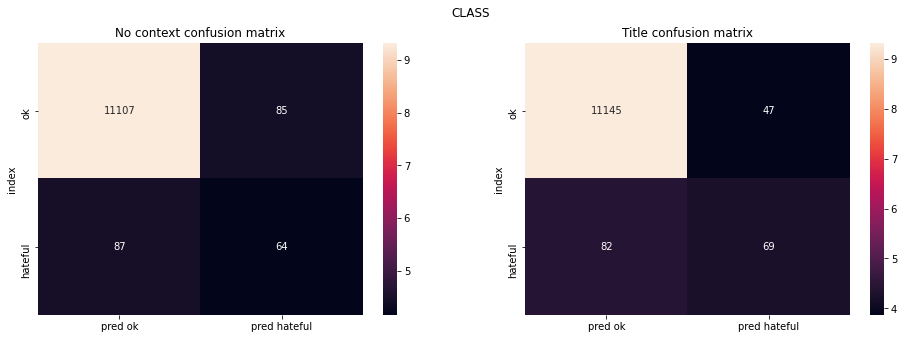

In [58]:
characteristic = "CLASS"
char_df = build_char_df(characteristic)

char_gold = char_df["label"] > 0
no_context_pred = char_df["no-context-pred"] > 0.5 
context_pred = char_df["title-pred"] > 0.5



plt.figure(figsize=(16, 5))
plt.suptitle(characteristic)
for i, (title, pred) in enumerate([
        ("No context confusion matrix", no_context_pred),
        ("Title confusion matrix", context_pred),
        ]):
    cm = pd.DataFrame(
        confusion_matrix(char_gold, pred)
    )

    cm.columns = ["pred ok", "pred hateful"]

    cm["index"] = ["ok", "hateful"]

    cm.set_index("index", inplace=True)

    normalized = np.log(1+cm)
    #normalized = (cm - cm.mean(axis=0)) / cm.std(axis=0)
    plt.subplot(1, 2, i+1)
    sns.heatmap(normalized, annot=cm, fmt="")
    plt.title(title)

Mejora precisión notablemente! El recall bastante menos

In [59]:
char_df.loc[(char_gold & context_pred & (~no_context_pred))].sort_values(["no-context-pred", "title-pred"], ascending=[True, False])

,text,title,label,no-context-pred,title-pred
id,,,,,
405004,[USER] Puaj la NEGRADA vagabunda\nRasca testículos,Otro día de marchas y cortes en el centro porteño: 3 caravanas se movilizaron en apoyo al Gobierno,1,0.000000,1.000000
379373,[USER] Puede ser gaseándolos también,"Las organizaciones sociales salieron al cruce de la acusación de Sergio Berni por la toma de tierras: ""La falta de vivienda no se resuelve con balas""",1,0.000000,1.000000
379350,"[USER] No , se resuelve con un misil","Las organizaciones sociales salieron al cruce de la acusación de Sergio Berni por la toma de tierras: ""La falta de vivienda no se resuelve con balas""",1,0.000000,0.933333
379362,"[USER] Si, los podemos cagar matando a todos y listo","Las organizaciones sociales salieron al cruce de la acusación de Sergio Berni por la toma de tierras: ""La falta de vivienda no se resuelve con balas""",1,0.000000,0.866667
405191,[USER] Entre la negrada y los corruptos éste país está condenado.,Limpiar la basura arrojada en la marcha por Milagro Sala costó 570 mil pesos,1,0.066667,1.000000
402258,"[USER] apoyan la dictadura estos negros de mierda jaja que envidia les tienen a los ricos jaja apoyan el impuesto a los ricos? sabían que los ricos generan riqueza, empresas, negocios y dan empleo? si se van del país los que se joden son ustedes los pobres","El oficialismo convoca a una ""caravana federal"" en apoyo al Gobierno y al impuesto a las grandes fortunas",1,0.066667,0.866667
405013,"[USER] Vagos, lacras!!!",Otro día de marchas y cortes en el centro porteño: 3 caravanas se movilizaron en apoyo al Gobierno,1,0.133333,1.000000
329915,"[USER] A los okupas, bala..",Toma de tierras en Guernica: los ocupantes hicieron un festival en protesta anticipada por el desalojo que ordenó la justicia,1,0.133333,1.000000
379377,[USER] Con balas no...con palos y cárcel!!,"Las organizaciones sociales salieron al cruce de la acusación de Sergio Berni por la toma de tierras: ""La falta de vivienda no se resuelve con balas""",1,0.266667,0.933333


Veamos los falsos positivos de no-context que con title clasificamos como negativos 

In [62]:
char_df.loc[(~char_gold & ~context_pred & no_context_pred)].sort_values(["no-context-pred", "title-pred"], ascending=[False, True])

,text,title,label,no-context-pred,title-pred
id,,,,,
336722,[USER] Cárcel,Pidieron la detención de la mujer que violó la cuarentena y les arrojó gas pimienta a los policías,0,1.000000,0.000000
336751,[USER] Un palazo,Pidieron la detención de la mujer que violó la cuarentena y les arrojó gas pimienta a los policías,0,1.000000,0.000000
397026,[USER] Bala,Detienen a la hermana del jugador de River Nicolás de la Cruz con 40 kilos de cocaína,0,1.000000,0.000000
358445,[USER] Balas para todes,"El pasacalles de los vecinos de Isidro Casanova con una advertencia a los ladrones: ""Si venís a robar, no llamamos a la Policía""",0,1.000000,0.000000
349340,[USER] Dijo lo que muchos pensamos...,"Paul McCartney: ""Los chinos necesitan ser más limpios y menos medievales""",0,1.000000,0.000000
367731,[USER] Un héroe,"El panadero que mató a un ladrón en La Matanza: ""No soy un asesino, estoy arrepentido""",0,1.000000,0.000000
360776,[USER] Otro parásito,"Javier Milei confirmó que va ""a militar en política"" junto a José Luis Espert para que ""en 35 años la Argentina sea primera potencia mundial""",0,1.000000,0.000000
360823,[USER] Otro parásito .,"Javier Milei confirmó que va ""a militar en política"" junto a José Luis Espert para que ""en 35 años la Argentina sea primera potencia mundial""",0,1.000000,0.000000
404716,[USER] Bala,"Usurpación en Cariló. Cumbia y champagne, así festejaban en la casa tomada",0,1.000000,0.066667


## WOMEN

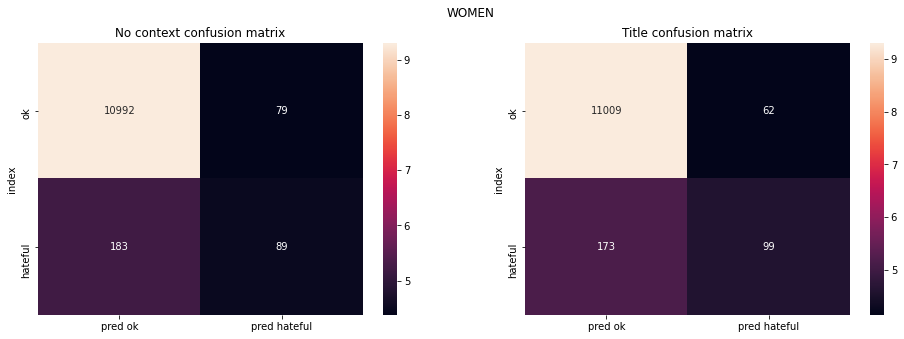

In [63]:
characteristic = "WOMEN"
char_df = build_char_df(characteristic)

char_gold = char_df["label"] > 0
no_context_pred = char_df["no-context-pred"] > 0.5 
context_pred = char_df["title-pred"] > 0.5



plt.figure(figsize=(16, 5))
plt.suptitle(characteristic)
for i, (title, pred) in enumerate([
        ("No context confusion matrix", no_context_pred),
        ("Title confusion matrix", context_pred),
        ]):
    cm = pd.DataFrame(
        confusion_matrix(char_gold, pred)
    )

    cm.columns = ["pred ok", "pred hateful"]

    cm["index"] = ["ok", "hateful"]

    cm.set_index("index", inplace=True)

    normalized = np.log(1+cm)
    #normalized = (cm - cm.mean(axis=0)) / cm.std(axis=0)
    plt.subplot(1, 2, i+1)
    sns.heatmap(normalized, annot=cm, fmt="")
    plt.title(title)

Veamos donde contexto ayudó a encontrar

In [66]:
char_df[char_gold & ~no_context_pred & context_pred].sort_values(["no-context-pred", "title-pred"], ascending=[True, False])

,text,title,label,no-context-pred,title-pred
id,,,,,
349498,[USER] Deben tener el estómago de Terminator.,Los fans de Florencia Kirchner le piden casamiento por Instagram,1,0.000000,0.866667
344425,[USER] Vieja ridícula [EMOJI] cara vomitando [EMOJI][EMOJI] cara vomitando [EMOJI][EMOJI] cara vomitando [EMOJI],"Alicia Castro le pide al Gobierno que ""no confíe"" en la vacuna de Oxford para el coronavirus y pruebe ""la rusa, china y cubana""",1,0.000000,0.733333
388237,[USER] A ver si le pasa lo mismo a Nancy Pazos quiero ver si defiende al chorro esta mujer es fea x dentro y horrible x fuera,El inesperado cruce entre la China Suárez y Nancy Pazos por el caso del jubilado que mató a un ladrón en Quilmes,1,0.000000,0.666667
369300,[USER] Que se puede esperar de una mina q eStando embarazada de su pareja se transaba a un chondo en el auto[EMOJI] mujer con la mano en la frente [EMOJI][EMOJI] mujer con la mano en la frente [EMOJI][EMOJI] mujer con la mano en la frente [EMOJI]. A no olvidar[EMOJI] cara lanzando un beso [EMOJI],"Juana Viale: ""¿Termina este mandato el Gobierno?""",1,0.000000,0.666667
380829,[USER] Hay que comerse al termotanque de lipidos,¿More Rial encontró el amor en un personal trainer?,1,0.000000,0.600000
388208,[USER] La bella vs la gorda tarada,El inesperado cruce entre la China Suárez y Nancy Pazos por el caso del jubilado que mató a un ladrón en Quilmes,1,0.000000,0.533333
388222,[USER] La bella vs la gorda tarada,El inesperado cruce entre la China Suárez y Nancy Pazos por el caso del jubilado que mató a un ladrón en Quilmes,1,0.000000,0.533333
355169,"[USER] Hijadept,, ojala pronto recibas la visita de alguno de esos gusanos. Te van a quedar. Ganas de apoyar al. Gobierno? Larva rastrera gorda. Decerebrada","Ofelia Fernández apoyó al Gobierno en la polémica por los presos y apuntó a la Justicia que ""odia a las mujeres""",1,0.066667,1.000000
380846,[USER] Mira las noticias porongas que ponen. No la toca nadie a la gorda esa,¿More Rial encontró el amor en un personal trainer?,1,0.066667,0.666667


In [69]:
pd.options.display.max_rows = 180
char_df[char_gold & ~no_context_pred & ~context_pred].sort_values(["no-context-pred", "title-pred"], ascending=[True, True])

,text,title,label,no-context-pred,title-pred
id,,,,,
397704,[USER] Faltó que se enganchó al hijo de sofovich para seguir adelante [EMOJI] cara con mano sobre la boca [EMOJI],"Mora Godoy cierra su escuela de tango y remata su vestuario para ""poder seguir adelante""",1,0.000000,0.000000
387339,[USER] Y pero en sus redes va a seguir mostrando el orto,"Ivana Nadal se cansó de que la criticaran y sorprendió con su respuesta: ""Gracias a Dios a fin de año me voy del país""",1,0.000000,0.000000
369254,[USER] Por favor LA NACION semejante reventada opinando de nuestro LÍDER ALBERTO FERNÁNDEZ Y DEL PATRIOTA ARGENTINA HUGO MOYANO \nUNA REVENTADA MANOSEADA DE NOMBRE JUANA VIALE ES VERGONZOSO QUE NOMBRE A ALBERTO FERNÁNDEZ Y A HUGO MOYANO. \nLOS ENSUCIA CON SOLO MENCIONAR SUS NOMBRES \nAMÉNN,"Juana Viale, sobre la foto de Alberto Fernández y Hugo Moyano: ""Si lo hacen ellos, ¿por qué no lo puedo hacer yo?""",1,0.000000,0.000000
387749,[USER] Gil... que bueno que te haya pasado... seguro eran dos gatos que llamaste así que no armes tanta historia,"""Mica"" y ""Maru"", las viudas negras de WhatsApp que drogaron a un empresario y le robaron más de 70 mil dólares",1,0.000000,0.000000
387751,[USER] Gil... que bueno que te haya pasado... seguro eran dos gatos que llamaste así que no armes tanta historia,"""Mica"" y ""Maru"", las viudas negras de WhatsApp que drogaron a un empresario y le robaron más de 70 mil dólares",1,0.000000,0.000000
387753,[USER] Y una era negra posta.,"""Mica"" y ""Maru"", las viudas negras de WhatsApp que drogaron a un empresario y le robaron más de 70 mil dólares",1,0.000000,0.000000
387758,[USER] Y una era negra posta.,"""Mica"" y ""Maru"", las viudas negras de WhatsApp que drogaron a un empresario y le robaron más de 70 mil dólares",1,0.000000,0.000000
402600,[USER] Igual ya está vieja,Keira Knightley no volverá a filmar escenas de sexo dirigidas por hombres,1,0.000000,0.000000
338095,"[USER] Son como pervertidos simulando ser heavy remodernos"" En realidad un desconche diría mi amiga.. Mmmm pobre criatura.","Vive con sus dos novios y atiende ""la policlínica"" del amor libre: 5 preguntas para abrir una relación y sobrevivir al intento",1,0.000000,0.000000


A ver, de lo que vemos:

- Hay sustancialmente más falsos negativos sobre la categoría mujer => veamos ahí!
- Hay muy pocos de apariencia

In [72]:
(false_positives[extended_hate_categories].mean() - hateful[extended_hate_categories].mean()) / std

CALLS        -0.47331
WOMEN        -0.43051
LGBTI        -0.32420
RACISM       -0.66105
CLASS        -0.32420
POLITICS     -0.43754
DISABLED     -0.25542
APPEARANCE   -0.49147
CRIMINAL     -0.46874
dtype: float64

Con **falsos positivos** tenemos:

- 